<a href="https://colab.research.google.com/github/baroulescientifique/Tutorials_for_my_students/blob/main/detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hello everyone!
Welcome to this notebook that is gonna be part of my Object Detection Series** 

The main goal here is to show you how you can easily predict bounding boxes using regression in tensorflow.

So definitely feel free to make as much changes as you want in the code in order to fit it to you dataset or annotations files.

In [2]:
import urllib.request
import os
import logging
import tarfile
from scipy import io
logging.basicConfig(level = logging.DEBUG)
import glob
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import load_img, img_to_array
logger  = logging.getLogger(__name__)

def download(url, folder, filename):
  """
  this function intends to help you download the
  dataset given the link.
  Feel free to skip  it if you have the dataset already downloaded
  """


  # if the folder does not exists
  if not os.path.exists(folder):
    logger.info(f'the folder {folder} does not exist, we will create it')
    os.makedirs(folder)

  file_path = os.path.sep.join([folder, filename])
  # check if the file_path exists
  if os.path.exists(file_path):
    logger.info('the file already exists, no dowloading needed')
    return file_path
  
  # Otherwise here we can download the file
  temp_name, _ = urllib.request.urlretrieve(url, filename=file_path)
  logger.info(f'the file {file_path} has been downloaded... filesize={os.stat(temp_name).st_size} ')

  return file_path


In [3]:

def _get_data():
  """
  This is another function that downloads the whole dataset at once.
  But you  can skip it as well if you have the dataset saved on your disk.
  """
  logger = logging.getLogger(__name__)
  categories = download(url=categories_link, folder='./Data', filename='categories.tar')
  tar = tarfile.open(categories)
  tar.extractall('dataset/')
  logger.info(f'{categories} extracted successfully')
  tar.close()

  annotations = download(url=annotations_link, folder='./Data', filename='annotations.tar')
  tar = tarfile.open(annotations)
  tar.extractall('dataset/')
  logger.info(f'{annotations} extracted successfully')
  tar.close()

  return categories, annotations
  

**NB :** In  my case , i have the files already in my google drive.
So if you dont have the files , please download them before proceeding further.
Will put the link to the dataset at the bottom of the notebook.

In [4]:
# here we extract the images files 
image_file = '/content/drive/My Drive/Folder/101_ObjectCategories.tar.gz'
tar = tarfile.open(image_file)
tar.extractall('Images/')
tar.close()

In [5]:
# here we extract the annotations files
annotation_file = '/content/drive/My Drive/Folder/Annotations.tar'
tar = tarfile.open(annotation_file)
tar.extractall('Images/')
tar.close()

In [6]:
image_files = []

for f in sorted(glob.glob('/content/Images/101_ObjectCategories/airplanes/*')):
  image_files.append(f)

# checking out a couple of lines
image_files[:10]

['/content/Images/101_ObjectCategories/airplanes/image_0001.jpg',
 '/content/Images/101_ObjectCategories/airplanes/image_0002.jpg',
 '/content/Images/101_ObjectCategories/airplanes/image_0003.jpg',
 '/content/Images/101_ObjectCategories/airplanes/image_0004.jpg',
 '/content/Images/101_ObjectCategories/airplanes/image_0005.jpg',
 '/content/Images/101_ObjectCategories/airplanes/image_0006.jpg',
 '/content/Images/101_ObjectCategories/airplanes/image_0007.jpg',
 '/content/Images/101_ObjectCategories/airplanes/image_0008.jpg',
 '/content/Images/101_ObjectCategories/airplanes/image_0009.jpg',
 '/content/Images/101_ObjectCategories/airplanes/image_0010.jpg']

In [ ]:
for a in sorted(glob.glob('/content/Images/Annotations/Airplanes_Side_2/*')):
  a = io.loadmat(a)
  print(a['box_coord'][0])
  break

[ 30 137  49 349]


In [7]:
# Here we fetch the annnotation from the extracted dataset
image_annotations = []

for a in sorted(glob.glob('/content/Images/Annotations/Airplanes_Side_2/*')):
  a = io.loadmat(a)
  (xmin, xmax, ymin, ymax) = a['box_coord'][0]
  image_annotations.append((xmin, ymin, xmax, ymax))

# let's have a look at the annotations data
image_annotations[:10]

[(30, 49, 137, 349),
 (35, 59, 153, 342),
 (36, 47, 135, 331),
 (24, 47, 141, 342),
 (18, 48, 146, 339),
 (24, 48, 126, 344),
 (23, 49, 122, 344),
 (29, 51, 119, 344),
 (29, 50, 137, 344),
 (32, 55, 106, 335)]

In [8]:
# We can now prepare our data for training
data = []
filenames = []
boxes = []
for f, a in zip(image_files, image_annotations):
  (xmin, ymin, xmax, ymax) = a 
  img = cv2.imread(f)
  (h, w) = img.shape[:2]
  # we scale all the coordinates
  xmin = float(xmin)/h
  xmax = float(xmax)/h
  ymin = float(ymin)/w
  ymax = float(ymax)/w

  image_data = load_img(f, target_size=(224, 224))
  image_data = img_to_array(image_data)

  boxes.append((xmin, ymin, xmax, ymax))
  data.append(image_data)
  filenames.append(f)

In [9]:
# It's highly advised to normalise our data 
# this results in optimizing the training process
data = np.array(data, dtype=np.float32)/255

In [10]:
# Casting the boxes to float32
boxes = np.array(boxes, dtype=np.float32)

In [11]:
# Split the data in training and testing
from sklearn.model_selection import train_test_split
split = train_test_split(data, boxes, filenames, test_size=0.1, random_state=42)
(train_data, test_data) = split[:2]
(train_boxes, test_boxes) = split[2:4]
(train_files, test_files) = split[4:]

In [12]:
# Let's check our shapes to make sure that everything is ok.
print(train_data.shape)
print(train_boxes.shape)
print(len(train_files))

(720, 224, 224, 3)
(720, 4)
720


In [13]:
# Now we create  our model 
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

def create_model():
  vgg = VGG16(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(224, 224, 3)))
  vgg.trainable = False
  flatten = vgg.output
  flatten = layers.Flatten()(flatten)
  # FC header 
  bboxHead = layers.Dense(128, activation='relu')(flatten)
  bboxHead = layers.Dense(64, activation='relu')(bboxHead)
  bboxHead = layers.Dense(32, activation='relu')(bboxHead)
  bboxHead = layers.Dense(4, activation='relu')(bboxHead)

  model = models.Model(inputs=vgg.input, outputs=bboxHead)

  return model

In [14]:
from tensorflow.keras import optimizers
opt = optimizers.Adam(learning_rate=1e-4)
# create the model
model = create_model()

58892288/58889256 [==============================] - 1s 0us/step


In [15]:
# compile the  model 
model.compile(loss='mse', optimizer=opt)

In [16]:
# get the model summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [17]:
history = model.fit(train_data, train_boxes, batch_size=32, epochs=25, validation_data=(test_data, test_boxes))

Epoch 1/25
23/23 [==============================] - 4s 159ms/step - loss: 0.0528 - val_loss: 0.0164
Epoch 2/25
23/23 [==============================] - 3s 119ms/step - loss: 0.0164 - val_loss: 0.0158
Epoch 3/25
23/23 [==============================] - 3s 120ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 4/25
23/23 [==============================] - 3s 120ms/step - loss: 0.0124 - val_loss: 0.0134
Epoch 5/25
23/23 [==============================] - 3s 120ms/step - loss: 0.0120 - val_loss: 0.0134
Epoch 6/25
23/23 [==============================] - 3s 120ms/step - loss: 0.0117 - val_loss: 0.0132
Epoch 7/25
23/23 [==============================] - 3s 121ms/step - loss: 0.0115 - val_loss: 0.0132
Epoch 8/25
23/23 [==============================] - 3s 121ms/step - loss: 0.0114 - val_loss: 0.0131
Epoch 9/25
23/23 [==============================] - 3s 122ms/step - loss: 0.0113 - val_loss: 0.0131
Epoch 10/25
23/23 [==============================] - 3s 123ms/step - loss: 0.0112 - val_loss: 0.0130

In [18]:
# Please change this location with whatever location you want to save the model to 
model.save('/content/drive/My Drive/Folder/detector.h5')

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(1, 26), history.history['loss'], label='train_loss')
plt.plot(np.arange(1, 26), history.history['val_loss'], label='val_loss')
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
#plt.savefig('model/plot.png')
plt.savefig('/content/drive/My Drive/Folder/plot.png')

(141, 405, 3)


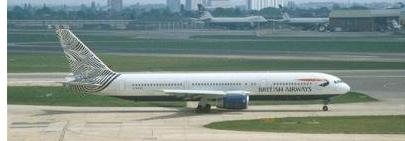

In [20]:
# Now let's take an image randomly and check 
img = cv2.imread(test_files[45])
print(img.shape)
cv2_imshow(img)

In [21]:
# We prepare the image data before passing it to the model
img = load_img(test_files[45], target_size=(224, 224))
#print(type(img))
img = img_to_array(img)/255
img = np.expand_dims(img, axis=0)
img.shape

(1, 224, 224, 3)

In [22]:
# Time to get the predictions
pred = model.predict(img)[0]
(xmin, ymin, xmax, ymax) = pred
# print the predictions
print(pred)

[0.         0.10970722 0.7964516  0.8360159 ]


In [23]:
# Then now we rescale back the coordinates
image = cv2.imread(test_files[45])
(h, w) = image.shape[:2]
#print(image.shape[:2])

xmin = int(xmin * h)
xmax = int(xmax * h)
ymin = int(ymin * w)
ymax = int(ymax * w)

In [24]:
# let's draw the boxes around the image 
r = cv2.rectangle(image, (ymin, xmin), (ymax, xmax), (0, 0, 255), 2)

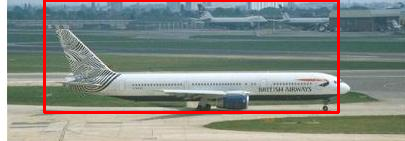

In [25]:
cv2_imshow(image)

(116, 395, 3)


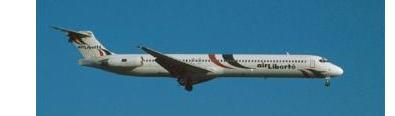

In [26]:
# Lets take one more example :
img = cv2.imread(test_files[12])
print(img.shape)
cv2_imshow(img)

[0.         0.15435466 0.7937785  0.9869057 ]


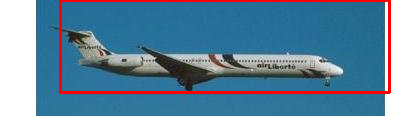

In [28]:
# We prepare the image data before passing it to the model
img = load_img(test_files[12], target_size=(224, 224))
#print(type(img))
img = img_to_array(img)/255
img = np.expand_dims(img, axis=0)

# Time to get the predictions
pred = model.predict(img)[0]
(xmin, ymin, xmax, ymax) = pred
# print the predictions
print(pred)

# Then now we rescale back the coordinates
image = cv2.imread(test_files[12])
(h, w) = image.shape[:2]
#print(image.shape[:2])

xmin = int(xmin * h)
xmax = int(xmax * h)
ymin = int(ymin * w)
ymax = int(ymax * w)

# let's draw the boxes around the image 
r = cv2.rectangle(image, (ymin, xmin), (ymax, xmax), (0, 0, 255), 2)

cv2_imshow(image)

 **Thanks for following the tutorial !
If you have any questions, please feel free to reach out to me at *diabyoumar22@yahoo.fr*. In the next tutorial we gonna work with the famous "Cat/Dog" dataset.**